In [157]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import math
from ddsketch import DDSketch
import time

In [49]:
EMBEDDING_DIM = 768
NUM_TREES = 10
NUM_EMBEDDINGS = 35_167_920

# Indicates target size for all embeddings in a leaf node.
# Treat this like a 'page size', in that the client will load it all at once.
TARGET_LEAF_SIZE_BYTES = 10 * (1024 * 1024)
EMBEDDING_SIZE_BYTES = EMBEDDING_DIM * 8
TARGET_LEAF_NUM_EMBEDDINGS = TARGET_LEAF_SIZE_BYTES // EMBEDDING_SIZE_BYTES

TREE_DEPTH = math.ceil(math.log2(NUM_EMBEDDINGS) - math.log2(TARGET_LEAF_NUM_EMBEDDINGS))

In [50]:
TREE_DEPTH

15

In [53]:
random_vectors = np.random.normal(size=(NUM_TREES, math.floor(math.pow(2, TREE_DEPTH - 1)), EMBEDDING_DIM))

In [54]:
random_vectors.shape

(10, 16384, 768)

In [59]:
random_vectors.nbytes

1006632960

In [56]:
sample_emb = np.array(doc["emb"])

In [57]:
rand_dot_prods = random_vectors @ sample_emb

In [63]:
random_vectors.shape[:2]

(10, 16384)

In [132]:
docs = load_dataset(f"Cohere/wikipedia-22-12-en-embeddings", split="train", streaming=True)

Resolving data files:   0%|          | 0/253 [00:00<?, ?it/s]

In [133]:
[dim_i, dim_j] = random_vectors.shape[:2]
sketches = [[ DDSketch() for _  in range(dim_j)] for _ in range(dim_i)]

- A + B: 100 docs / 60 secs
- A: 100 docs / 11 secs
- loop only: 100 docs / 3 secs

In [152]:
def run(A=True, B=True, batch_size=1000, num_batches=20):
    limit = batch_size * num_batches

    num_docs = 0
    elapsed = 0
    last_time = time.time()

    num_docs_snapshots = []
    elapsed_snapshots = []
    for doc_batch in docs.select_columns(["id", "emb"]).iter(batch_size=batch_size):
        for emb in doc_batch["emb"]:
            num_docs += 1

            if num_docs % batch_size == 0:
                print(f"num docs: {num_docs}")
                num_docs_snapshots.append(num_docs)

                now = time.time()
                elapsed += (now - last_time)
                last_time = now
                print(f"elapsed secs: {elapsed}")
                elapsed_snapshots.append(elapsed)

            if num_docs > limit:
                return num_docs_snapshots, elapsed_snapshots

        if A or B:
            doc_emb = np.array(emb)
            doc_dot_prods = random_vectors @ doc_emb

            if B:
                for i in range(dim_i):
                    for j in range(dim_j):
                        sketch_ij = sketches[i][j]
                        elt = doc_dot_prods[i][j]

                        sketch_ij.add(elt)

In [135]:
%%time
run(A=False, B=False) # loop only

CPU times: user 723 ms, sys: 381 ms, total: 1.1 s
Wall time: 3.44 s


In [136]:
%%time
run(A=True) # A only

CPU times: user 643 ms, sys: 316 ms, total: 959 ms
Wall time: 3.61 s


In [137]:
%%time
run(A=True, B=True) # A+B 

CPU times: user 628 ms, sys: 364 ms, total: 992 ms
Wall time: 3.51 s


In [153]:
num_docs1000, elapsed1000 = run(A=True, B=True, batch_size=1000, num_batches=20)

num docs: 1000
elapsed secs: 4.663612365722656
num docs: 2000
elapsed secs: 6.376014947891235
num docs: 3000
elapsed secs: 8.041577577590942
num docs: 4000
elapsed secs: 9.697885990142822
num docs: 5000
elapsed secs: 11.301748991012573
num docs: 6000
elapsed secs: 12.994666814804077
num docs: 7000
elapsed secs: 14.620779991149902
num docs: 8000
elapsed secs: 16.251445531845093
num docs: 9000
elapsed secs: 18.004244804382324
num docs: 10000
elapsed secs: 19.677164316177368
num docs: 11000
elapsed secs: 26.74987530708313
num docs: 12000
elapsed secs: 28.37944746017456
num docs: 13000
elapsed secs: 29.99368906021118
num docs: 14000
elapsed secs: 31.584722995758057
num docs: 15000
elapsed secs: 33.178316831588745
num docs: 16000
elapsed secs: 34.82650542259216
num docs: 17000
elapsed secs: 36.44316744804382
num docs: 18000
elapsed secs: 38.224344968795776
num docs: 19000
elapsed secs: 39.88154220581055
num docs: 20000
elapsed secs: 41.48381853103638


In [154]:
num_docs100, elapsed100 = run(A=True, B=True, batch_size=100, num_batches=20)

num docs: 100
elapsed secs: 3.6992907524108887
num docs: 200
elapsed secs: 4.329741477966309
num docs: 300
elapsed secs: 4.977502346038818
num docs: 400
elapsed secs: 5.580400228500366
num docs: 500
elapsed secs: 6.185368061065674
num docs: 600
elapsed secs: 6.781221389770508
num docs: 700
elapsed secs: 7.380982875823975
num docs: 800
elapsed secs: 7.972169876098633
num docs: 900
elapsed secs: 8.56275224685669
num docs: 1000
elapsed secs: 9.15562629699707
num docs: 1100
elapsed secs: 9.766481637954712
num docs: 1200
elapsed secs: 10.3656325340271
num docs: 1300
elapsed secs: 10.964234352111816
num docs: 1400
elapsed secs: 11.550699472427368
num docs: 1500
elapsed secs: 12.145993709564209
num docs: 1600
elapsed secs: 12.776294708251953
num docs: 1700
elapsed secs: 13.3701491355896
num docs: 1800
elapsed secs: 13.96072268486023
num docs: 1900
elapsed secs: 14.559600353240967
num docs: 2000
elapsed secs: 15.152703285217285


In [155]:
num_docs10000, elapsed10000 = run(A=True, B=True, batch_size=10_000, num_batches=20)

num docs: 10000
elapsed secs: 14.900989532470703
num docs: 20000
elapsed secs: 29.50673198699951
num docs: 30000
elapsed secs: 44.315420627593994
num docs: 40000
elapsed secs: 61.423789978027344
num docs: 50000
elapsed secs: 76.43049216270447
num docs: 60000
elapsed secs: 91.82649970054626
num docs: 70000
elapsed secs: 109.27441358566284
num docs: 80000
elapsed secs: 125.08651494979858
num docs: 90000
elapsed secs: 140.12612986564636
num docs: 100000
elapsed secs: 155.0685203075409
num docs: 110000
elapsed secs: 170.20307850837708
num docs: 120000
elapsed secs: 186.81411361694336
num docs: 130000
elapsed secs: 203.7083067893982
num docs: 140000
elapsed secs: 222.49331331253052
num docs: 150000
elapsed secs: 241.20133543014526
num docs: 160000
elapsed secs: 258.6295771598816
num docs: 170000
elapsed secs: 274.4133954048157
num docs: 180000
elapsed secs: 292.8266053199768
num docs: 190000
elapsed secs: 309.83854246139526
num docs: 200000
elapsed secs: 325.9315710067749


In [162]:
num_docs100000, elapsed100000 = run(A=True, B=True, batch_size=100_000, num_batches=20)

In [159]:
df = pd.DataFrame({
    "batch_100": pd.Series(num_docs100) / pd.Series(elapsed100),
    "batch_1000": pd.Series(num_docs1000) / pd.Series(elapsed1000),
    "batch_10000": pd.Series(num_docs10000) / pd.Series(elapsed10000)
})

<Axes: >

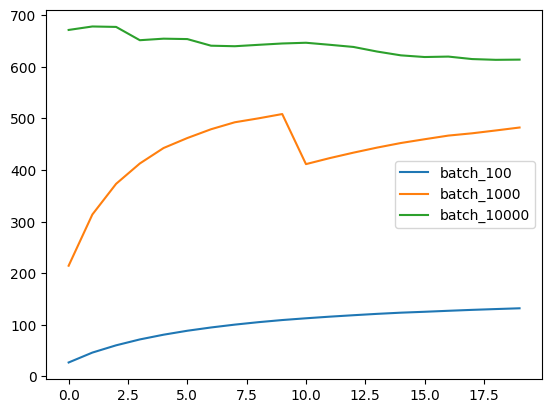

In [161]:
df.plot(kind="line")